In [3]:
# Enable all CPU cores
from tqdm import tqdm
import pandas as pd
import re
import pandas as pd

# Read the file content
def parse_to_datafame(file_path):
  with open(file_path, "r") as file:
      content = file.read()
  # Define a regex pattern to extract the test case and its details
  pattern = r" structure (?P<structure>.+)\s+nat\s+(?P<nat>\d+)\s+nprim\s+(?P<nprim>\d+)\s+maxl\s+(?P<maxl>\d+)\s+max_nnl\s+(?P<max_nnl>\d+)\s+mean_nnl\s+(?P<mean_nnl>\d+)\s+max_nsh\s+(?P<max_nsh>\d+)\s+cpu_time\s+(?P<cpu_time>[\d.]+)\s+gpu_gb_in\s+(?P<gpu_gb_in>[\d.]+)\s+gpu_gb_out\s+(?P<gpu_gb_out>[\d.]+)\s+gpu_gb_total\s+(?P<gpu_gb_total>[\d.]+)\s+gpu_between_atoms\s+(?P<gpu_between_atoms>[\d.]+)\s+gpu_in_atoms\s+(?P<gpu_in_atoms>[\d.]+)\s+gpu_time\s+(?P<gpu_time>[\d.]+)\s+gpu_walltime\s+(?P<gpu_walltime>[\d.]+)"

  # Use re.finditer to extract all matches
  matches = re.finditer(pattern, content)

  # Create a list of dictionaries to store the extracted data
  data = []
  for match in matches:
      data.append(match.groupdict())

  # Convert the list of dictionaries into a pandas DataFrame
  df = pd.DataFrame(data)

# Convert numeric columns to appropriate data types
  numeric_columns = [
      'nat', 'nprim', 'maxl', 'max_nnl', 'mean_nnl', 'max_nsh',
      'cpu_time', 'gpu_gb_in', 'gpu_gb_out', 'gpu_gb_total',
      'gpu_between_atoms', 'gpu_in_atoms', 'gpu_time', 'gpu_walltime'
  ]
  # Convert the numeric columns to float
  df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)

  # Display the DataFrame
  df = df.sort_values('nat')
  return df

option = 'rtx4060'
!rm -rf notes/capture/{option}
!mkdir -p notes/capture/{option}
!rm -rf notes/data/{option}
!mkdir -p notes/data/{option}
for ncore in tqdm([1, 2, 4, 8, 16, 32]):
  ncore = str(ncore)
  !OMP_NUM_THREADS={ncore} meson test -C build/ hamiltonian --verbose -t 0 > notes/capture/{option}/{ncore}cpu.txt
  df = parse_to_datafame(f"notes/capture/{option}/{ncore}cpu.txt")
  df.to_csv(f"notes/data/{option}/{ncore}cpu.csv", index=False)

100%|██████████| 6/6 [04:30<00:00, 45.06s/it]


In [4]:
!nproc
!lscpu

32
Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          39 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   32
  On-line CPU(s) list:    0-31
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Core(TM) i9-14900HX
    CPU family:           6
    Model:                183
    Thread(s) per core:   2
    Core(s) per socket:   24
    Socket(s):            1
    Stepping:             1
    CPU(s) scaling MHz:   25%
    CPU max MHz:          5800.0000
    CPU min MHz:          800.0000
    BogoMIPS:             4838.40
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 s
                          s ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc 
                          art arch_perfmon pebs bts rep_good nopl xtopology nons
                          top_tsc cpuid

In [2]:
!nvidia-smi

Tue May 20 16:03:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.20             Driver Version: 570.133.20     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 NVL                On  |   00000000:81:00.0 Off |                    0 |
| N/A   40C    P0             89W /  400W |       0MiB /  95830MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:

df = parse_to_datafame(file_path)

!mkdir -p notes/data/h100
df.to_csv("notes/data/h100/1cpu.csv", index=False)

alkanes = df[df['structure'].str.contains('alkane')]
# remove alkanes from this
df = df[~df['structure'].str.contains('alkane')]

In [15]:
df

,structure,nat,nprim,maxl,max_nnl,mean_nnl,max_nsh,cpu_time,gpu_gb_in,gpu_gb_out,gpu_gb_total,gpu_between_atoms,gpu_in_atoms,gpu_time,gpu_walltime
0,H2,2,6,0,1,0,1,0.046279,0.000001,0.000000,0.000002,15.345344,0.563552,15.908895,404.605368
1,dna,387,6,2,164,69,3,262.431469,0.232068,0.231803,0.463871,6.736480,0.893664,7.630144,194.146841
2,1lyz-lysozyme,1102,6,2,312,99,3,727.279442,1.749900,1.748891,3.498792,19.675520,1.189568,20.865088,1180.243877
3,103l-hydrolase,1404,6,2,311,99,3,933.680251,2.816439,2.815150,5.631588,24.598848,1.340288,25.939137,1718.053144


In [16]:
alkanes

,structure,nat,nprim,maxl,max_nnl,mean_nnl,max_nsh,cpu_time,gpu_gb_in,gpu_gb_out,gpu_gb_total,gpu_between_atoms,gpu_in_atoms,gpu_time,gpu_walltime
4,alkane_10,30,6,1,25,13,2,1.825460,0.000324,0.000317,0.000641,0.823232,0.453344,1.276576,2.266567
5,alkane_342,1026,6,1,30,21,2,102.745777,0.370811,0.370542,0.741353,2.398752,0.441568,2.840320,269.232462
6,alkane_674,2022,6,1,30,21,2,246.529994,1.439677,1.439146,2.878823,4.461248,0.625600,5.086848,881.008705
7,alkane_1006,3018,6,1,30,21,2,433.527972,3.206922,3.206130,6.413052,6.475072,0.790656,7.265728,2001.972865
8,alkane_1338,4014,6,1,30,21,2,667.186074,5.672547,5.671493,11.344040,8.541536,0.900000,9.441536,3383.965184
9,alkane_1671,5013,6,1,30,21,2,1131.577439,8.847136,8.845819,17.692955,10.508832,1.150688,11.659520,5046.280392


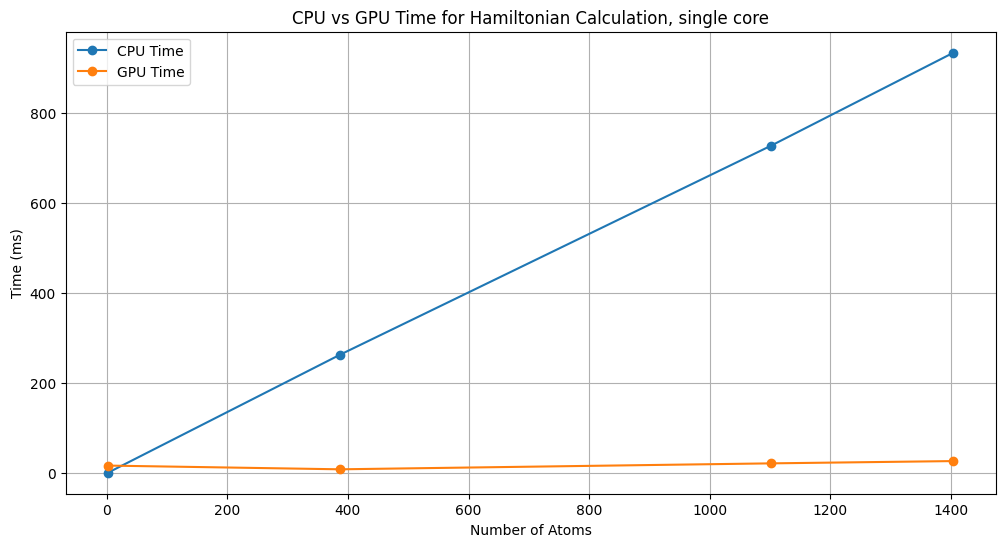

In [17]:
import matplotlib.pyplot as plt

# Line plot for time vs number of atoms, and compare CPU and GPU times
plt.figure(figsize=(12, 6))
plt.plot(df['nat'], df['cpu_time'], label='CPU Time', marker='o')
plt.plot(df['nat'], df['gpu_time'], label='GPU Time', marker='o')
plt.xlabel('Number of Atoms')
plt.ylabel('Time (ms)')
plt.title('CPU vs GPU Time for Hamiltonian Calculation, single core')
plt.legend()
plt.grid()
plt.savefig('notes/figures/h100_1cpu_vs_gpu_time_ms_proteins.png')
plt.show()

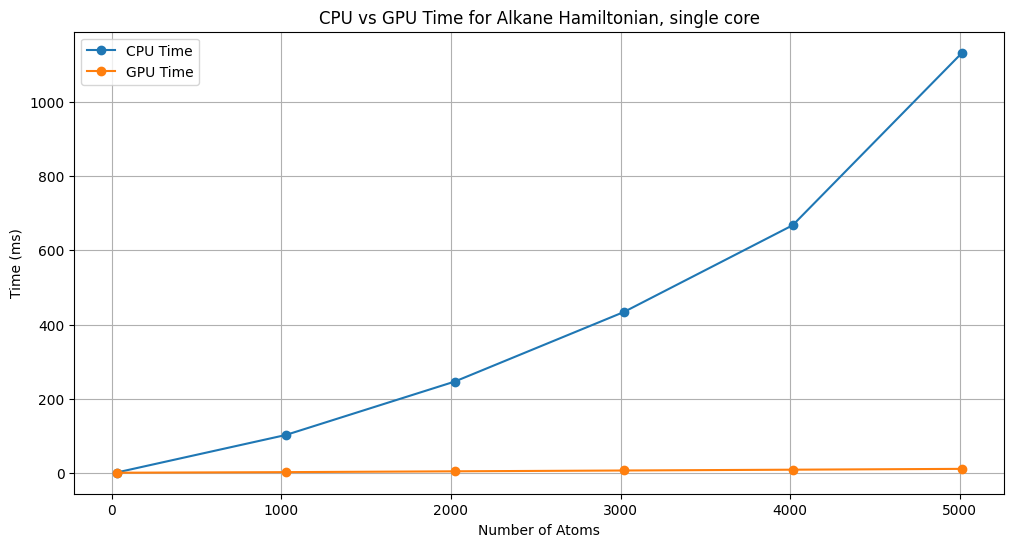

In [18]:
# Plot for alkanes
plt.figure(figsize=(12, 6))
plt.plot(alkanes['nat'], alkanes['cpu_time'], label='CPU Time', marker='o')
plt.plot(alkanes['nat'], alkanes['gpu_time'], label='GPU Time', marker='o')
plt.xlabel('Number of Atoms')
plt.ylabel('Time (ms)')
plt.title('CPU vs GPU Time for Alkane Hamiltonian, single core')
plt.legend()
plt.grid()
plt.savefig('notes/figures/h100_1cpu_vs_gpu_alkanes.png')

 14%|█▍        | 1/7 [00:53<05:23, 53.89s/it]

^C


 29%|██▊       | 2/7 [01:36<03:55, 47.16s/it]

In [ ]:


df.to_csv("notes/data/h100/64cpu.csv", index=False)

# remove alkanes from this
alkanes = df[df['structure'].str.contains('alkane')]
df = df[~df['structure'].str.contains('alkane')]

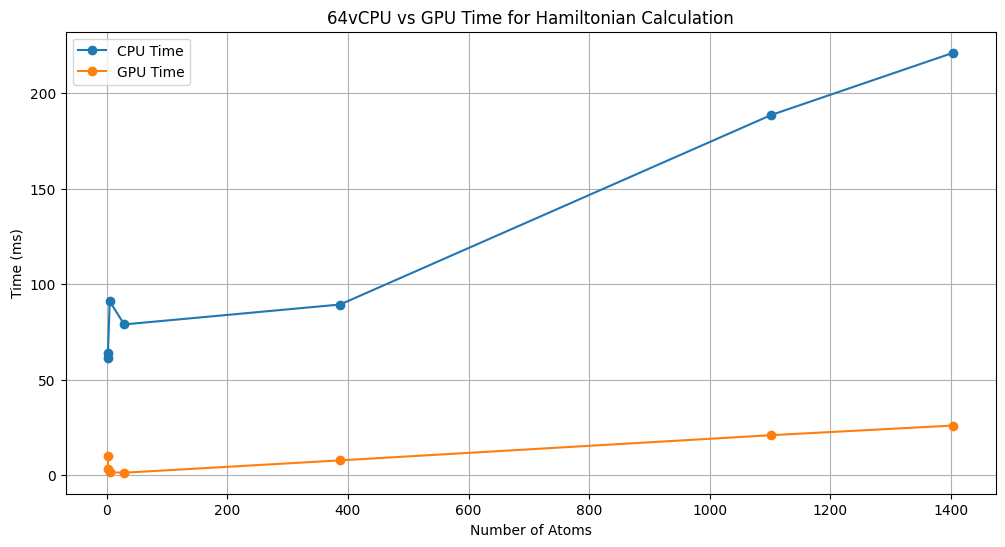

In [22]:
import matplotlib.pyplot as plt

# Line plot for time vs number of atoms, and compare CPU and GPU times
plt.figure(figsize=(12, 6))
plt.plot(df['nat'], df['cpu_time'], label='CPU Time', marker='o')
plt.plot(df['nat'], df['gpu_time'], label='GPU Time', marker='o')
plt.xlabel('Number of Atoms')
plt.ylabel('Time (ms)')
plt.title('64vCPU vs GPU Time for Hamiltonian Calculation')
plt.legend()
plt.grid()
plt.savefig('notes/figures/64cpu-vs-h100.png')
plt.show()

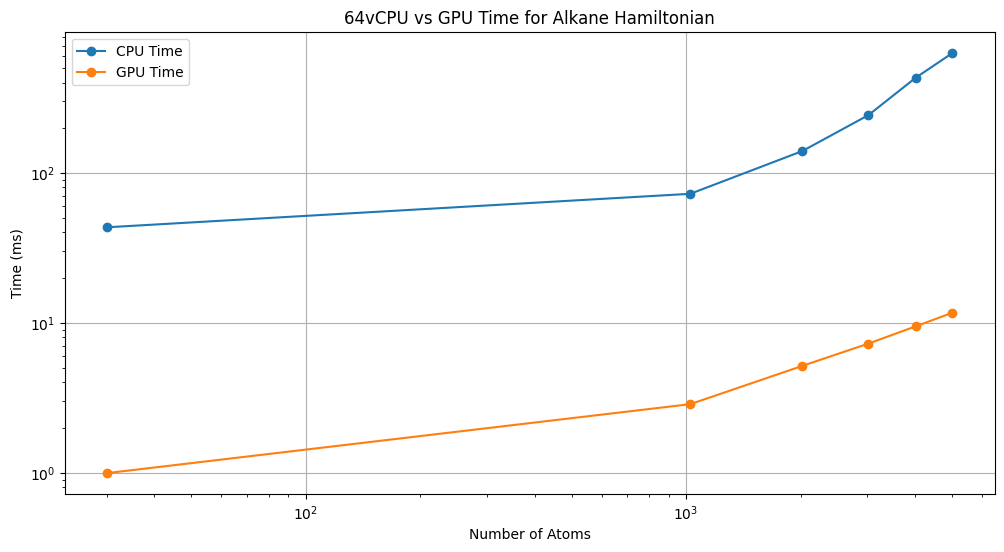

In [23]:
# Line logplot for time vs number of atoms for alkanes
plt.figure(figsize=(12, 6))
plt.plot(alkanes['nat'], alkanes['cpu_time'], label='CPU Time', marker='o')
plt.plot(alkanes['nat'], alkanes['gpu_time'], label='GPU Time', marker='o')
plt.xlabel('Number of Atoms')
plt.ylabel('Time (ms)')
plt.title('64vCPU vs GPU Time for Alkane Hamiltonian')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.savefig('notes/figures/64cpu_vs_h100_alkane.png')
plt.show()